In [2]:
!pip install torch torchvision timm matplotlib

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import timm
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#hyperparameters and configs
BATCH_SIZE = 64
LR = 1e-4
N_EPOCHS =10
NUM_CLASSES =10

In [5]:
# data transformations
transform = transforms.Compose([
    transforms.Resize((224,224)), #original data is 32x32
    transforms.ToTensor(), # making the data "numbers"
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#load CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [15]:
dataset = datasets.CIFAR10(root='./data',
train =True,
download=True,
transform=transform)


train_dataset = datasets.CIFAR10(root='./data',
train =True,
download=True,
transform=transform_train)

val_dataset = datasets.CIFAR10(root='./data',
train =False,
download=True,
transform=transform_val)

100%|██████████| 170498071/170498071 [00:03<00:00, 46497879.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [17]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [18]:
#data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader= DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [19]:
class ViTModel(nn.Module):
  def __init__(self, num_classes):
    super(ViTModel, self).__init__()
    self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
    self.model.head = nn.Linear(self.model.head.in_features,num_classes)

  def forward(self, x):
    return self.model(x)

In [20]:
# initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTModel(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/10, Batch 1/625, Loss: 2.6835
Epoch [1/10] completed in 3.44 seconds
Epoch 1/10, Batch 101/625, Loss: 0.0489
Epoch [1/10] completed in 226.41 seconds
Epoch 1/10, Batch 201/625, Loss: 0.1129
Epoch [1/10] completed in 473.51 seconds
Epoch 1/10, Batch 301/625, Loss: 0.1026
Epoch [1/10] completed in 720.83 seconds
Epoch 1/10, Batch 401/625, Loss: 0.1167
Epoch [1/10] completed in 967.41 seconds
Epoch 1/10, Batch 501/625, Loss: 0.0718
Epoch [1/10] completed in 1214.40 seconds
Epoch 1/10, Batch 601/625, Loss: 0.0873
Epoch [1/10] completed in 1461.65 seconds
	Epoch [1/10], Train Loss: 0.1979, Validation Loss: 0.1462, Validation Accuracy: 95.23%
Epoch 2/10, Batch 1/625, Loss: 0.1085
Epoch [2/10] completed in 2.95 seconds
Epoch 2/10, Batch 101/625, Loss: 0.2140
Epoch [2/10] completed in 250.18 seconds
Epoch 2/10, Batch 201/625, Loss: 0.1717
Epoch [2/10] completed in 497.01 seconds
Epoch 2/10, Batch 301/625, Loss: 0.0300
Epoch [2/10] completed in 743.43 seconds
Epoch 2/10, Batch 401/625, 

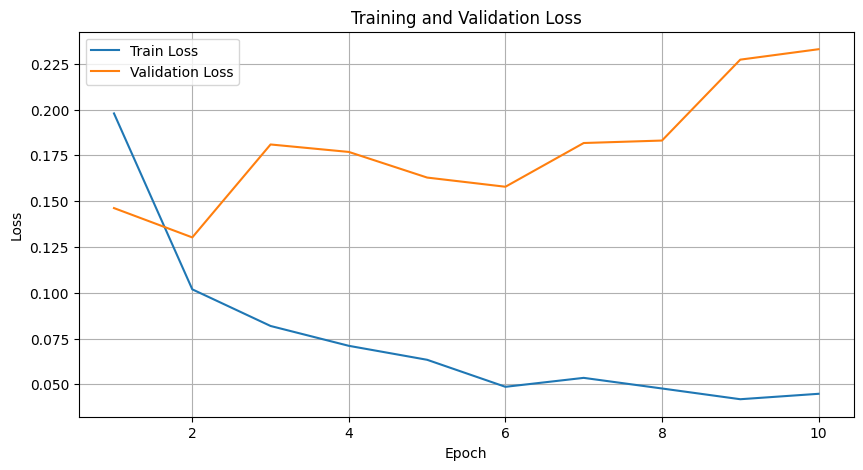

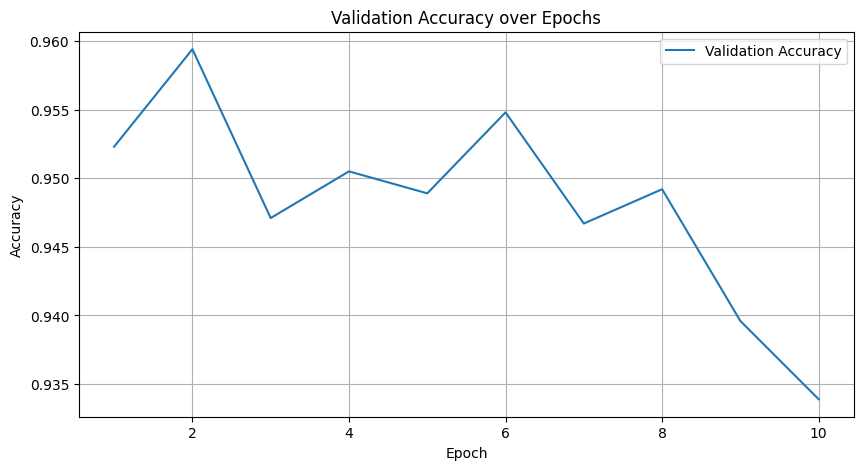

In [11]:
#training and validation loop
train_losses = []
val_losses = []
val_accuracies = []
log_interval = 100


for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0.0
    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch+1}/{N_EPOCHS}, Batch {batch_idx+1}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')
            epoch_duration = time.time() - start_time
            print(f'Epoch [{epoch+1}/{N_EPOCHS}] completed in {epoch_duration:.2f} seconds')

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    
    print(f'\tEpoch [{epoch+1}/{N_EPOCHS}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Loss: {val_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]*100:.2f}%')

#save model
torch.save(model.state_dict(), 'vit_cifar10.pth')

  # Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import os
print(os.getcwd())

/kaggle/working


In [8]:
print(os.listdir('/kaggle/working'))

['.virtual_documents']


In [9]:
!find / -name "vit_cifar10.pth" 2>/dev/null

In [21]:
print(model)

ViTModel(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
   

In [22]:
torch.save(model.state_dict(), '/kaggle/working/vit_cifar10.pth')
print("Model saved successfully.")

Model saved successfully.


In [23]:
print(os.listdir('/kaggle/working'))

['.virtual_documents', 'vit_cifar10.pth', 'data']


In [24]:
import zipfile

# Create a Zip file containing the saved model
with zipfile.ZipFile('/kaggle/working/vit_cifar10.zip', 'w') as zipf:
    zipf.write('/kaggle/working/vit_cifar10.pth', arcname='vit_cifar10.pth')

In [28]:
from IPython.display import FileLink

# Create a link for your saved model file
FileLink('/kaggle/working/vit_cifar10.pth')

/kaggle/working/vit_cifar10.pth

In [30]:
from IPython.display import FileLink

# Create a link for your saved model file
FileLink('/kaggle/working/vit_cifar10.pth')

/kaggle/working/vit_cifar10.pth

In [31]:
from IPython.display import FileLinks

# Generate download links for all files in /kaggle/working/
FileLinks('/kaggle/working')

/kaggle/working/
  vit_cifar10.pth
  vit_cifar10.zip
/kaggle/working/data/
  cifar-10-python.tar.gz
/kaggle/working/data/cifar-10-batches-py/
  batches.meta
  data_batch_4
  data_batch_2
  readme.html
  data_batch_3
  data_batch_5
  data_batch_1
  test_batch